## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [45]:
PATH = Path('data/lyft')
list(PATH.iterdir())

[PosixPath('data/lyft/train_masks'), PosixPath('data/lyft/train')]

In [61]:
def isolate_roads(filename):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == 7] = 255
    img_np_R[img_np_R == 6] = 255

    img_np_R[img_np_R != 255] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = Path('data/lyft/train_masks')
    image.save(dest/filename.name)

In [80]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

# def show_img(im, figsize=(10,10), ax=None, seg=False, channel=None):
#     if not ax: fig,ax = plt.subplots(figsize=figsize)
#     new_img = np.copy(im) # Prevent the original image from being modified
#     if seg:
#         new_img = new_img[:,:,0] # Grab just the red channel from the RGB image
#         if channel:
#             new_img[new_img != channel] = 0 # Display only the requested classes (roads etc)
#     ax.imshow(new_img.astype(np.int32))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     return ax

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

The following code takes the original labelled images and converts them to a more usable format. Run this code only once.

In [59]:
seg_PATH = Path('train/CameraSeg')
original_segs = list(seg_PATH.iterdir())

# for image in original_segs:
#     isolate_roads(image)

In [64]:
PATH = Path('data/lyft')
input_images = PATH/'train'
output_images = PATH/'train_masks'

list(input_images.iterdir())[:3]

[PosixPath('data/lyft/train/5.png'),
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/train/0.png')]

In [65]:
list(output_images.iterdir())[:3]

[PosixPath('data/lyft/train_masks/5.png'),
 PosixPath('data/lyft/train_masks/88.png'),
 PosixPath('data/lyft/train_masks/0.png')]

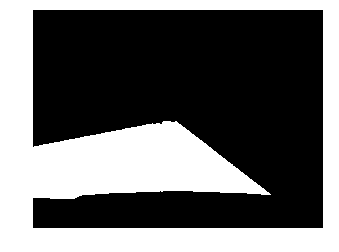

In [82]:
test_seg_image = open_image(list(output_images.iterdir())[0])
show_img(test_seg_image)

## Resize images

In [84]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'
sz = 128
bs = 64

In [85]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image_no_norm(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [87]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [88]:
val_idxs = list(range(len(x_names)//5)) # 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [90]:
len(val_x),len(trn_x),trn_x[0], trn_y[0]

(200,
 800,
 PosixPath('data/lyft/train/284.png'),
 PosixPath('data/lyft/train_masks/284.png'))

In [91]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [92]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [93]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [24]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
# learn.summary()

In [94]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [95]:
flatten_channel = Lambda(lambda x: x[:,0])

In [96]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [97]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

epoch      trn_loss   val_loss   <lambda>                      
    0      -5051.123016 -59149375733.76 0.0       



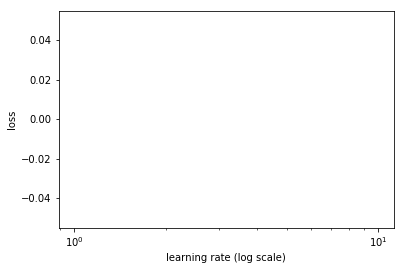

In [98]:
learn.lr_find()
learn.sched.plot()

In [99]:
lr=4e-2

In [100]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                      
    0      -1008.764706 -27586.462578 0.274355  
    1      -8885.77229 -37176.250938 0.702047                  
    2      -24789.699808 -72966.656875 0.678736                
    3      -45312.926632 -101635.88375 7.2e-05                 
    4      -65388.809393 -117884.29625 3.8e-05                 



[array([-117884.29625]), 3.7841796875e-05]

In [101]:
learn.save('tmp')

In [102]:
learn.load('tmp')

In [103]:
py,ay = learn.predict_with_targs()

In [104]:
ay.shape

(200, 128, 128)

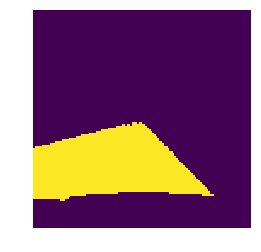

In [105]:
show_img(ay[0]);

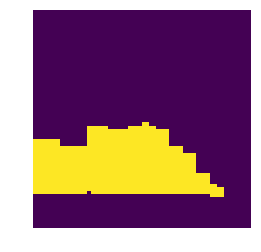

In [109]:
show_img(py[0]>1500); # why???

In [108]:
(py[0])[80]

array([2185.329  , 2183.976  , 2186.9695 , 2185.586  , 2260.1875 , 2258.7646 , 2256.16   , 2254.7454 ,
       2240.524  , 2239.0847 , 2267.225  , 2265.7583 , 2317.3022 , 2315.8655 , 2317.6008 , 2316.1646 ,
       2509.2073 , 2507.7234 , 2510.6877 , 2509.1797 , 2504.726  , 2503.1868 , 2483.3386 , 2481.8008 ,
       2535.8455 , 2534.324  , 2538.567  , 2537.0164 , 2522.7761 , 2521.2708 , 2520.6545 , 2519.1367 ,
       2508.2617 , 2506.778  , 2520.0698 , 2518.5525 , 2517.6174 , 2516.1172 , 2516.5579 , 2515.0564 ,
       2534.461  , 2532.9382 , 2565.3313 , 2563.7505 , 2546.5947 , 2545.06   , 2554.5688 , 2553.015  ,
       2541.433  , 2539.901  , 2546.1084 , 2544.5496 , 2560.7366 , 2559.1792 , 2549.3577 , 2547.8074 ,
       2565.1565 , 2563.5952 , 2569.0298 , 2567.437  , 2556.2915 , 2554.742  , 2554.6887 , 2553.1243 ,
       2494.8782 , 2493.4136 , 2505.3252 , 2503.8289 , 2500.1016 , 2498.627  , 2499.1226 , 2497.6475 ,
       2528.6555 , 2527.1423 , 2556.2793 , 2554.711  , 2535.5127 , 2533.9

The predicted image's pixels are on a spectrum, instead of binary. Let's convert the pixels to binary instead, using the 75th percentile as the threshold.

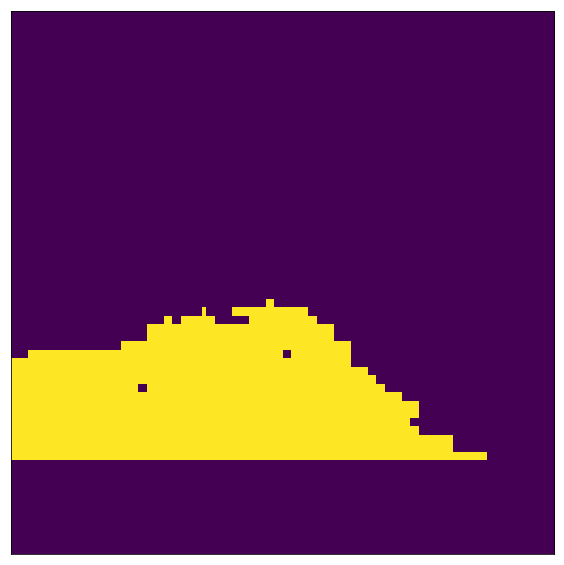

In [74]:
thresh=np.percentile(py[0], 83) # experimentally determined threshold -- be careful!
pred = np.copy(py[0])
pred.shape
pred[pred<thresh] = 0
pred[pred>=thresh] = 255
show_img(pred)

Looks like it could use some work.

In [75]:
learn.unfreeze()

In [76]:
learn.bn_freeze(True)

In [77]:
lrs = np.array([lr/100, lr/10, lr])/4

In [78]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                      
    0      -4555540199.572595 -429242695024.64 0.035085  
    1      -7.851467022270049e+21 -1.304126918543095e+23 0.0       
    2      -1.4383030897754064e+23 -5.6610679373380986e+23 0.0       
    3      -3.660998032971119e+23 -1.0201700296950732e+24 0.0       
    4      -6.277001621693905e+23 -1.4256973253949704e+24 0.0       
    5      -9.020855964852407e+23 -1.7804586164724814e+24 0.0       
    6      -1.1752721600859072e+24 -2.0921513487654692e+24 0.0       
    7      -1.4421898676237846e+24 -2.3675368650253453e+24 0.0       
    8      -1.6998967846962985e+24 -2.6068426827818294e+24 0.0       
    9      -1.9430750359994321e+24 -2.817639541799427e+24 0.0       
    10     -2.1689648146631824e+24 -2.998517442136434e+24 0.0       
    11     -2.37777983420414e+24 -3.157802921249703e+24 0.0       
    12     -2.5693714179398314e+24 -3.2950118789286627e+24 0.0       
    13     -2.7440474965124175e+24 -3.4116320681

[array([-3.75703e+24]), 0.0]

In [79]:
py,ay = learn.predict_with_targs()

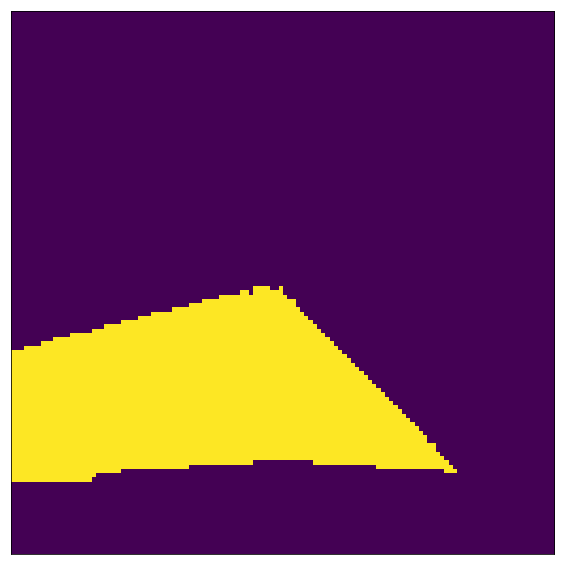

In [80]:
show_img(ay[0]);

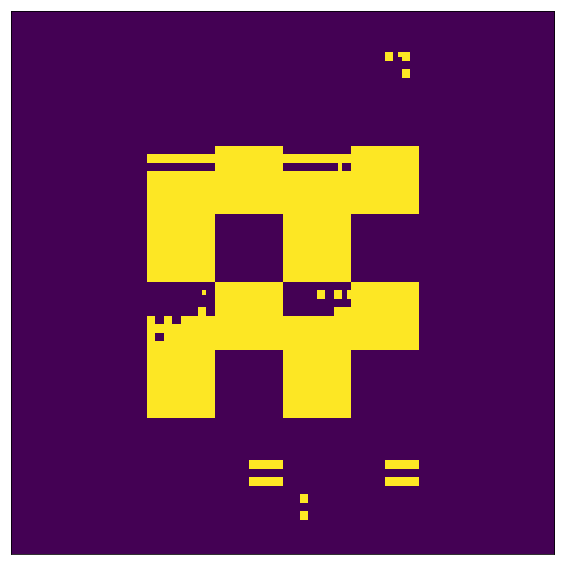

In [81]:
thresh=np.percentile(py[0], 83) # experimentally determined threshold -- be careful!
pred = np.copy(py[0])
pred.shape
pred[pred<thresh] = 0
pred[pred>=thresh] = 255
show_img(pred)